<a href="https://colab.research.google.com/github/harvard-visionlab/psy1406/blob/main/2022/psy1406_facenetcnn_facetransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Psy1406 - Facenet vs. Face Transformer

A Notebook for comparing the representations of a CNNFaceNet vs. FaceTransormer.

cnn-facenet: https://github.com/timesler/facenet-pytorch

face-transformer: https://github.com/zhongyy/Face-Transformer

# Step 0 - General Setup

Running this section will download some demo images and install some code needed to run the following setps. You should only need to run this step once at the start of a session. However, sometimes Google restarts your environment (e.g., if you are idle for a while, they shut down your session), so you might have to re-run this step if that happens.

In [1]:
# INSTALL FACENET 
!pip install facenet-pytorch
!pip install vit_pytorch

In [2]:
# DOWNLOAD EXAMPLE IMAGES
!mkdir -p images
!wget -c https://www.dropbox.com/s/7tqlvb69lvx570h/BaldBear.jpg -q --show-progress -O /content/images/BaldBear.jpg
!wget -c https://www.dropbox.com/s/nbct96tf4oqnr2q/BrownBear2.jpg -q --show-progress -O /content/images/BrownBear.jpg
!wget -c https://www.dropbox.com/s/65p68g331kby809/Gorilla.jpg -q --show-progress -O /content/images/Gorilla.jpg
!wget -c https://www.dropbox.com/s/be1hkifaz8u04y9/DiCaprio_Anchor.jpg -q --show-progress -O /content/images/DiCaprio_Anchor.jpg
!wget -c https://www.dropbox.com/s/xn3y46bpccopdl7/DiCaprio_HardNegative.jpg -q --show-progress -O /content/images/DiCaprio_HardNegative.jpg
!wget -c https://www.dropbox.com/s/8londclzzyj3oji/DiCaprio_NegativeClooney.jpg -q --show-progress -O /content/images/DiCaprio_NegativeClooney.jpg
!wget -c https://www.dropbox.com/s/ddlfya3368jdhci/DiCaprio_Positive.jpg -q --show-progress -O /content/images/DiCaprio_Positive.jpg

!wget -c https://www.dropbox.com/s/xyhnau99qmve89e/pitt1.jpg -q --show-progress -O /content/images/pitt1.jpg
!wget -c https://www.dropbox.com/s/z7qqz49yjw60vh0/pitt2.jpg -q --show-progress -O /content/images/pitt2.jpg
!wget -c https://www.dropbox.com/s/qkpvcr1hodiemn3/clooney1.jpg -q --show-progress -O /content/images/clooney1.jpg
!wget -c https://www.dropbox.com/s/y0o1gyuhf33gf1l/clooney2.jpg -q --show-progress -O /content/images/clooney2.jpg


In [3]:
!mkdir -p weights
!wget -c https://www.dropbox.com/s/vlgldq0khdtxwox/Backbone_VIT_Epoch_2_Batch_20000_Time_2021-01-12-16-48_checkpoint.pth -q --show-progress -O /content/weights/vit_checkpoint.pth
!wget -c https://www.dropbox.com/s/ss3bvbigk0ngv9u/Backbone_VITs_Epoch_2_Batch_12000_Time_2021-03-17-04-05_checkpoint.pth -q --show-progress -O /content/weights/vits_checkpoint.pth

In [4]:
import os
import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from glob import glob
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
%config InlineBackend.figure_format='retina'
# %matplotlib notebook
%matplotlib inline
sns.set(rc={'figure.figsize':(15.7,8.27)})
np.set_printoptions(suppress=True)

class ImageListDataset(Dataset):
    """"""

    def __init__(self, imgs, transform=None):
        self.root_dir = None
        self.files = imgs
        self.transform = transform

    def __getitem__(self, index):
        im = Image.open(self.files[index])
        if self.transform:
            im = self.transform(im)

        return im, 0, index

    def __len__(self):
        return len(self.files)

    def __repr__(self):
        _repr_indent = 4
        head = "Dataset " + self.__class__.__name__
        body = ["Number of Images: {}".format(self.__len__())]
        if self.root_dir is not None:
            body.append("Root location: {}".format(self.root_dir))
        if hasattr(self, "transform") and self.transform is not None:
            body += [repr(self.transform)]
        lines = [head] + [" " * _repr_indent + line for line in body]
        return '\n'.join(lines)


def get_dataset(image_pairs, root_dir=Path('images')):
    root_dir = Path(root_dir)
    transform = transforms.Compose([
        lambda x: x.convert('RGB'),
        transforms.Resize((224, 224)),
    ])
    imgs = [root_dir/img for imgs in image_pairs for img in imgs]
    dataset = ImageListDataset(imgs=imgs, transform=transform)

    return dataset


def show_grid(dataset):
    imgs = []
    for image_num in range(0, len(dataset), 2):
        imgs.append(np.hstack(
            [np.array(dataset[image_num][0]), np.array(dataset[image_num+1][0])]))
    imgs = np.vstack(imgs)

    return Image.fromarray(imgs)

'''
Utilities for instrumenting a torch model.
InstrumentedModel will wrap a pytorch model and allow hooking
arbitrary layers to monitor or modify their output directly.
'''

import torch
import numpy
import types
import copy
from collections import OrderedDict, defaultdict


class InstrumentedModel(torch.nn.Module):
    '''
    A wrapper for hooking, probing and intervening in pytorch Modules.
    Example usage:
    ```
    model = load_my_model()
    with inst as InstrumentedModel(model):
        inst.retain_layer(layername)
        inst.edit_layer(layername, ablation=0.5, replacement=target_features)
        inst(inputs)
        original_features = inst.retained_layer(layername)
    ```
    '''

    def __init__(self, model):
        super().__init__()
        self.model = model
        self._retained = OrderedDict()
        self._detach_retained = {}
        self._editargs = defaultdict(dict)
        self._editrule = {}
        self._hooked_layer = {}
        self._old_forward = {}
        if isinstance(model, torch.nn.Sequential):
            self._hook_sequential()

    def __enter__(self):
        return self

    def __exit__(self, type, value, traceback):
        self.close()

    def forward(self, *inputs, **kwargs):
        return self.model(*inputs, **kwargs)

    def retain_layer(self, layername, detach=True):
        '''
        Pass a fully-qualified layer name (E.g., module.submodule.conv3)
        to hook that layer and retain its output each time the model is run.
        A pair (layername, aka) can be provided, and the aka will be used
        as the key for the retained value instead of the layername.
        '''
        self.retain_layers([layername], detach=detach)

    def retain_layers(self, layernames, detach=True):
        '''
        Retains a list of a layers at once.
        '''
        self.add_hooks(layernames)
        for layername in layernames:
            aka = layername
            if not isinstance(aka, str):
                layername, aka = layername
            if aka not in self._retained:
                self._retained[aka] = None
                self._detach_retained[aka] = detach

    def stop_retaining_layers(self, layernames):
        '''
        Removes a list of layers from the set retained.
        '''
        self.add_hooks(layernames)
        for layername in layernames:
            aka = layername
            if not isinstance(aka, str):
                layername, aka = layername
            if aka in self._retained:
                del self._retained[aka]
                del self._detach_retained[aka]

    def retained_features(self, clear=False):
        '''
        Returns a dict of all currently retained features.
        '''
        result = OrderedDict(self._retained)
        if clear:
            for k in result:
                self._retained[k] = None
        return result

    def retained_layer(self, aka=None, clear=False):
        '''
        Retrieve retained data that was previously hooked by retain_layer.
        Call this after the model is run.  If clear is set, then the
        retained value will return and also cleared.
        '''
        if aka is None:
            # Default to the first retained layer.
            aka = next(self._retained.keys().__iter__())
        result = self._retained[aka]
        if clear:
            self._retained[aka] = None
        return result

    def edit_layer(self, layername, rule=None, **kwargs):
        '''
        Pass a fully-qualified layer name (E.g., module.submodule.conv3)
        to hook that layer and modify its output each time the model is run.
        The output of the layer will be modified to be a convex combination
        of the replacement and x interpolated according to the ablation, i.e.:
        `output = x * (1 - a) + (r * a)`.
        '''
        if not isinstance(layername, str):
            layername, aka = layername
        else:
            aka = layername

        # The default editing rule is apply_ablation_replacement
        if rule is None:
            rule = apply_ablation_replacement

        self.add_hooks([(layername, aka)])
        self._editargs[aka].update(kwargs)
        self._editrule[aka] = rule

    def remove_edits(self, layername=None):
        '''
        Removes edits at the specified layer, or removes edits at all layers
        if no layer name is specified.
        '''
        if layername is None:
            self._editargs.clear()
            self._editrule.clear()
            return

        if not isinstance(layername, str):
            layername, aka = layername
        else:
            aka = layername
        if aka in self._editargs:
            del self._editargs[aka]
        if aka in self._editrule:
            del self._editrule[aka]

    def add_hooks(self, layernames):
        '''
        Sets up a set of layers to be hooked.
        Usually not called directly: use edit_layer or retain_layer instead.
        '''
        needed = set()
        aka_map = {}
        for name in layernames:
            aka = name
            if not isinstance(aka, str):
                name, aka = name
            if self._hooked_layer.get(aka, None) != name:
                aka_map[name] = aka
                needed.add(name)
        if not needed:
            return
        for name, layer in self.model.named_modules():
            if name in aka_map:
                needed.remove(name)
                aka = aka_map[name]
                self._hook_layer(layer, name, aka)
        for name in needed:
            raise ValueError('Layer %s not found in model' % name)

    def _hook_layer(self, layer, layername, aka):
        '''
        Internal method to replace a forward method with a closure that
        intercepts the call, and tracks the hook so that it can be reverted.
        '''
        if aka in self._hooked_layer:
            raise ValueError('Layer %s already hooked' % aka)
        if layername in self._old_forward:
            raise ValueError('Layer %s already hooked' % layername)
        self._hooked_layer[aka] = layername
        self._old_forward[layername] = (layer, aka,
                                        layer.__dict__.get('forward', None))
        editor = self
        original_forward = layer.forward

        def new_forward(self, *inputs, **kwargs):
            original_x = original_forward(*inputs, **kwargs)
            x = editor._postprocess_forward(original_x, aka)
            return x
        layer.forward = types.MethodType(new_forward, layer)

    def _unhook_layer(self, aka):
        '''
        Internal method to remove a hook, restoring the original forward method.
        '''
        if aka not in self._hooked_layer:
            return
        layername = self._hooked_layer[aka]
        # Remove any retained data and any edit rules
        if aka in self._retained:
            del self._retained[aka]
            del self._detach_retained[aka]
        self.remove_edits(aka)
        # Restore the unhooked method for the layer
        layer, check, old_forward = self._old_forward[layername]
        assert check == aka
        if old_forward is None:
            if 'forward' in layer.__dict__:
                del layer.__dict__['forward']
        else:
            layer.forward = old_forward
        del self._old_forward[layername]
        del self._hooked_layer[aka]

    def _postprocess_forward(self, x, aka):
        '''
        The internal method called by the hooked layers after they are run.
        '''
        # Retain output before edits, if desired.
        if aka in self._retained:
            if self._detach_retained[aka]:
                self._retained[aka] = x.detach()
            else:
                self._retained[aka] = x
        # Apply any edits requested.
        rule = self._editrule.get(aka, None)
        if rule is not None:
            x = rule(x, self, **(self._editargs[aka]))
        return x

    def _hook_sequential(self):
        '''
        Replaces 'forward' of sequential with a version that takes
        additional keyword arguments: layer allows a single layer to be run;
        first_layer and last_layer allow a subsequence of layers to be run.
        '''
        model = self.model
        self._hooked_layer['.'] = '.'
        self._old_forward['.'] = (model, '.',
                                  model.__dict__.get('forward', None))

        def new_forward(this, x, layer=None, first_layer=None, last_layer=None):
            assert layer is None or (
                first_layer is None and last_layer is None)
            first_layer, last_layer = [str(layer) if layer is not None
                                       else str(d) if d is not None else None
                                       for d in [first_layer, last_layer]]
            including_children = (first_layer is None)
            for name, layer in this._modules.items():
                if name == first_layer:
                    first_layer = None
                    including_children = True
                if including_children:
                    x = layer(x)
                if name == last_layer:
                    last_layer = None
                    including_children = False
            assert first_layer is None, '%s not found' % first_layer
            assert last_layer is None, '%s not found' % last_layer
            return x
        model.forward = types.MethodType(new_forward, model)

    def close(self):
        '''
        Unhooks all hooked layers in the model.
        '''
        for aka in list(self._old_forward.keys()):
            self._unhook_layer(aka)
        assert len(self._old_forward) == 0


def apply_ablation_replacement(x, imodel, **buffers):
    if buffers is not None:
        # Apply any edits requested.
        a = make_matching_tensor(buffers, 'ablation', x)
        if a is not None:
            x = x * (1 - a)
            v = make_matching_tensor(buffers, 'replacement', x)
            if v is not None:
                x += (v * a)
    return x


def make_matching_tensor(valuedict, name, data):
    '''
    Converts `valuedict[name]` to be a tensor with the same dtype, device,
    and dimension count as `data`, and caches the converted tensor.
    '''
    v = valuedict.get(name, None)
    if v is None:
        return None
    if not isinstance(v, torch.Tensor):
        # Accept non-torch data.
        v = torch.from_numpy(numpy.array(v))
        valuedict[name] = v
    if not v.device == data.device or not v.dtype == data.dtype:
        # Ensure device and type matches.
        assert not v.requires_grad, '%s wrong device or type' % (name)
        v = v.to(device=data.device, dtype=data.dtype)
        valuedict[name] = v
    if len(v.shape) < len(data.shape):
        # Ensure dimensions are unsqueezed as needed.
        assert not v.requires_grad, '%s wrong dimensions' % (name)
        v = v.view((1,) + tuple(v.shape) +
                   (1,) * (len(data.shape) - len(v.shape) - 1))
        valuedict[name] = v
    return v


def subsequence(sequential, first_layer=None, last_layer=None,
                share_weights=False):
    '''
    Creates a subsequence of a pytorch Sequential model, copying over
    modules together with parameters for the subsequence.  Only
    modules from first_layer to last_layer (inclusive) are included.
    If share_weights is True, then references the original modules
    and their parameters without copying them.  Otherwise, by default,
    makes a separate brand-new copy.
    '''
    included_children = OrderedDict()
    including_children = (first_layer is None)
    for name, layer in sequential._modules.items():
        if name == first_layer:
            first_layer = None
            including_children = True
        if including_children:
            included_children[name] = layer if share_weights else (
                copy.deepcopy(layer))
        if name == last_layer:
            last_layer = None
            including_children = False
    if first_layer is not None:
        raise ValueError('Layer %s not found' % first_layer)
    if last_layer is not None:
        raise ValueError('Layer %s not found' % last_layer)
    if not len(included_children):
        raise ValueError('Empty subsequence')
    return torch.nn.Sequential(OrderedDict(included_children))

import os
import numpy as np
import pandas as pd
from pathlib import Path
from glob import glob
from pprint import pprint
from collections import OrderedDict

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from IPython.core.debugger import set_trace

alexnet_pytorch_blocks = OrderedDict([
    ('Conv1', ['features.0','features.1','features.2']),
    ('Conv2', ['features.3','features.4','features.5']),
    ('Conv3', ['features.6','features.7']),
    ('Conv4', ['features.8','features.9']),
    ('Conv5', ['features.10','features.11','features.12']),
    ('', ['avgpool']),
    ('fc6', ['classifier.0','classifier.1','classifier.2']),
    ('fc7', ['classifier.3','classifier.4','classifier.5']),
    ('fc8', ['classifier.6']),
])

def plot_results(df):
    pair_names = []
    for i, row in df.iterrows():
        img1 = row.image1.replace(".jpg","").replace(".png","").replace(".tiff","")
        img2 = row.image2.replace(".jpg","").replace(".png","").replace(".tiff","")
        pair_name = img1 + "_" + img2
        pair_names.append(pair_name)
    df['pair_name'] = pair_names    
    ax = sns.barplot(x="pair_name", y="euclidean_distance", data=df)
    ax.set_title("Euclidean Distance Between Pairs (larger = more different)", fontsize=20)
    return ax;

def plot_df(df, pairs=[0,1,2], title='', blocks=None, legend_loc=(0.25, 0.80), group_by='pair_num', ceiling=1, ylabel='correlation', legend_color=(0.95,0.95,0.95,1.0)):
    
    if pairs is None:
        #ax = plot_data(df, title, ymax=1.10, ymin=-0.20, hue=group_by, ylabel=ylabel)
        ax = plot_data(df[df.pair_num.isin(pairs)], title, ymax=1.10, ymin=-0.20, hue=group_by, ylabel=ylabel)
    else:
        ax = plot_data(df[df.pair_num.isin(pairs)], title, ymax=1.10, ymin=-0.20, hue=group_by, ylabel=ylabel)
    
    if blocks:
        draw_bg(blocks, ypos=1.03, legend_loc=legend_loc)
    
    L = ax.legend()
    legend_labels = ['image_pair']        
    
    for pair in pairs:
        label = df[df.pair_num == pair].iloc[0].image1.replace('.jpg', '') + '_vs_' + df[df.pair_num == pair].iloc[0].image2.replace('.jpg', '')
        legend_labels.append(label)        
    for label_num, label in enumerate(legend_labels):
        if label is not None: L.get_texts()[label_num].set_text(label)

    L.set_bbox_to_anchor(legend_loc)    
    
    return ax

def plot_data(df, title, ymax=.50, ymin=0.0, hue=None, ylabel='correlation'):
    sns.set(rc={'figure.figsize':(16.7,8.27)})
    sns.set_style("whitegrid", {'axes.grid' : False})
    ax = sns.lineplot(x="layer", y="y", hue=hue, data=df, linewidth=2)
    ax.set_title(title, fontsize=24);
    ax.set_ylabel(ylabel, fontsize=24, labelpad=15);
    ax.set_xlabel("layer", fontsize=24, labelpad=20);
    ax.set_ylim([ymin, ymax])
    plt.xticks(rotation=90);
    
    return ax

def draw_bg(blocks, ypos=0.475, alpha_b=.20, alpha_g=.15, legend_loc=(0.79, 0.80)):
    if blocks == None: return
    c = 0
    for idx, (block_name, layers) in enumerate(blocks.items()):
        n_layers = len(layers)
        for i in range(c, c+n_layers):
            if idx % 2 == 0:
                plt.axvspan(i-.5, i+.5, facecolor='b', alpha=alpha_b, lw=0)
            else:
                plt.axvspan(i-.5, i+.5, facecolor='gray', alpha=alpha_g, lw=0)
        plt.text(c+(n_layers)/2-.5, ypos, block_name, fontdict=None, fontsize=16, ha='center', va='center')
        c += n_layers
    plt.legend(facecolor=(0.95,0.95,0.95,1.0), bbox_to_anchor=legend_loc) 
    
def plot(df, legend_loc=(0.25, 0.70)):
    df['y'] = df['r']
    layer_name = lambda x: "{:02d}_{}".format(x.layer_num,x.layer_type.replace("BatchNorm2d","Norm").replace("GroupNorm", "Norm"))
    df['layer'] = df[['layer_num','layer_type']].apply(layer_name, axis=1)
    
    blocks = alexnet_pytorch_blocks
    
    pairs = df.pair_num.unique()
    
    ax = plot_df(df, blocks=blocks, pairs=pairs, legend_loc=legend_loc)

    return ax

import pandas as pd
from scipy.stats import pearsonr
from fastprogress import master_bar, progress_bar
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1
from IPython.core.debugger import set_trace

tfrm = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.ToTensor()
])

def compute_embeddings(dataset):
    print(f"Computing Embeddings (N={len(dataset)} images)")
    cache = {}
    mtcnn = MTCNN(image_size=160)
    resnet = InceptionResnetV1(pretrained='vggface2').eval()
    
    embeddings = []
    embedding = []
    for idx, (img, label, index) in enumerate(progress_bar(dataset)):
        
        # Get cropped and prewhitened image tensor
        img_cropped = None
        try:
          img_cropped = mtcnn(img)
        except:
          pass 
          
        if img_cropped is None:
            print("Warning, no human face detected, using center crop:", dataset.files[idx])
            img_cropped = tfrm(img)
            
        # Calculate embedding (unsqueeze to add batch dimension)
        img_embedding = resnet(img_cropped.unsqueeze(0))
        
        embedding.append(img_embedding)
        
        if len(embedding) == 2:
            embeddings.append(embedding)
            embedding = []
    
    return embeddings

def compare_embeddings(embeddings, image_pairs):
    df = pd.DataFrame(columns=['pair_num','image1','image2','euclidean_distance'])
    
    for pair_num, ((embed1, embed2), (image1, image2)) in enumerate(zip(embeddings, image_pairs)):
        df = df.append({
            "pair_num": pair_num,
            "image1": image1,
            "image2": image2, 
            "euclidean_distance": (embed1-embed2).pow(2).sum().item()
        }, ignore_index=True)
        
    return df

def get_layer(m, layers):
    layer = layers.pop(0)
    m = getattr(m, layer)
    if len(layers) > 0:
        return get_layer(m, layers)
    return m


def get_layers(model, parent_name='', layer_info=[]):
    for module_name, module in model.named_children():
        layer_name = parent_name + '.' + module_name
        if len(list(module.named_children())):
            layer_info = get_layers(module, layer_name, layer_info=layer_info)
        else:
            layer_info.append(layer_name.strip('.'))

    return layer_info


def get_layer_type(model, layer_name):
    m = get_layer(model, layer_name.split("."))
    return m.__class__.__name__


def convert_relu_layers(parent):
    for child_name, child in parent.named_children():
        if isinstance(child, nn.ReLU):
            setattr(parent, child_name, nn.ReLU(inplace=False))
        elif len(list(child.children())) > 0:
            convert_relu_layers(child)


def store_activations(model, layer_names):
    a = OrderedDict()
    for layer_num, layer_name in enumerate(layer_names):
        layer_type = get_layer_type(model.model, layer_name)
        X = model.retained_layer(layer_name)
        X = X.view(X.shape[0], -1)
        a[layer_name] = X
    return a


def compute_similarity(model, dataset):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # hook model
    layer_names = get_layers(model, parent_name='', layer_info=[])
    if not isinstance(model, nethook.InstrumentedModel):
        model = nethook.InstrumentedModel(model)
    for layer_name in layer_names:
        model.retain_layer(layer_name)

    model = model.to(device)
    model.eval()

    # create dataloader
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    dataset = ImageListDataset(imgs=dataset.files, transform=transform)
    dataloader = DataLoader(dataset, batch_size=1,
                            shuffle=False, num_workers=0, pin_memory=False)

    # compute similarity by layer
    df = pd.DataFrame(columns=['pair_num', 'image1', 'image2',
                               'layer_num', 'layer_name', 'layer_type', 'r'])
    pair_num = 0
    mb = master_bar(dataloader)
    for count, (imgs, labels, indexes) in enumerate(mb):
        with torch.no_grad():
            model(imgs.to(device))
        if count % 2 == 0:
            a1 = store_activations(model, layer_names)
            image1 = dataset.files[indexes].name
        if count % 2 == 1:
            a2 = store_activations(model, layer_names)
            image2 = dataset.files[indexes].name
            for layer_num, layer_name in enumerate(progress_bar(layer_names, parent=mb)):
                r = pearsonr(a1[layer_name].squeeze(),
                             a2[layer_name].squeeze())[0]
                layer_type = get_layer_type(model.model, layer_name)
                df = df.append({
                    "pair_num": pair_num,
                    "image1": image1,
                    "image2": image2,
                    "layer_num": layer_num,
                    "layer_name": layer_name,
                    "layer_type": layer_type,
                    "r": r,
                }, ignore_index=True)

            pair_num += 1

    df.pair_num = df.pair_num.astype(int)

    return df  

### vit face models

In [5]:
import torch
import torch.nn.functional as F
from einops import rearrange, repeat
from torch import nn

from torch.nn import Parameter
from IPython import embed

MIN_NUM_PATCHES = 16

class Softmax(nn.Module):
    r"""Implement of Softmax (normal classification head):
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            device_id: the ID of GPU where the model will be trained by model parallel.
                       if device_id=None, it will be trained on CPU without model parallel.
        """
    def __init__(self, in_features, out_features, device_id):
        super(Softmax, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.device_id = device_id

        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        self.bias = Parameter(torch.FloatTensor(out_features))
        nn.init.xavier_uniform_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, input, label):
        if self.device_id == None:
            out = F.linear(x, self.weight, self.bias)
        else:
            x = input
            sub_weights = torch.chunk(self.weight, len(self.device_id), dim=0)
            sub_biases = torch.chunk(self.bias, len(self.device_id), dim=0)
            temp_x = x.cuda(self.device_id[0])
            weight = sub_weights[0].cuda(self.device_id[0])
            bias = sub_biases[0].cuda(self.device_id[0])
            out = F.linear(temp_x, weight, bias)
            for i in range(1, len(self.device_id)):
                temp_x = x.cuda(self.device_id[i])
                weight = sub_weights[i].cuda(self.device_id[i])
                bias = sub_biases[i].cuda(self.device_id[i])
                out = torch.cat((out, F.linear(temp_x, weight, bias).cuda(self.device_id[0])), dim=1)
        return out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()



class ArcFace(nn.Module):
    r"""Implement of ArcFace (https://arxiv.org/pdf/1801.07698v1.pdf):
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            device_id: the ID of GPU where the model will be trained by model parallel.
                       if device_id=None, it will be trained on CPU without model parallel.
            s: norm of input feature
            m: margin
            cos(theta+m)
        """

    def __init__(self, in_features, out_features, device_id, s=64.0, m=0.50, easy_margin=False):
        super(ArcFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.device_id = device_id

        self.s = s
        self.m = m

        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        if self.device_id == None:
            cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        else:
            x = input
            sub_weights = torch.chunk(self.weight, len(self.device_id), dim=0)
            temp_x = x.cuda(self.device_id[0])
            weight = sub_weights[0].cuda(self.device_id[0])
            cosine = F.linear(F.normalize(temp_x), F.normalize(weight))
            for i in range(1, len(self.device_id)):
                temp_x = x.cuda(self.device_id[i])
                weight = sub_weights[i].cuda(self.device_id[i])
                cosine = torch.cat((cosine, F.linear(F.normalize(temp_x), F.normalize(weight)).cuda(self.device_id[0])),
                                   dim=1)
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        one_hot = torch.zeros(cosine.size())
        if self.device_id != None:
            one_hot = one_hot.cuda(self.device_id[0])
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + (
                    (1.0 - one_hot) * cosine)  # you can use torch.where if your torch.__version__ is 0.4
        output *= self.s

        return output


class CosFace(nn.Module):
    r"""Implement of CosFace (https://arxiv.org/pdf/1801.09414.pdf):
    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        device_id: the ID of GPU where the model will be trained by model parallel.
                       if device_id=None, it will be trained on CPU without model parallel.
        s: norm of input feature
        m: margin
        cos(theta)-m
    """

    def __init__(self, in_features, out_features, device_id, s=64.0, m=0.35):
        super(CosFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.device_id = device_id
        self.s = s
        self.m = m
        print("self.device_id", self.device_id)
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------

        if self.device_id == None:
            cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        else:
            x = input
            sub_weights = torch.chunk(self.weight, len(self.device_id), dim=0)
            temp_x = x.cuda(self.device_id[0])
            weight = sub_weights[0].cuda(self.device_id[0])
            cosine = F.linear(F.normalize(temp_x), F.normalize(weight))
            for i in range(1, len(self.device_id)):
                temp_x = x.cuda(self.device_id[i])
                weight = sub_weights[i].cuda(self.device_id[i])
                cosine = torch.cat((cosine, F.linear(F.normalize(temp_x), F.normalize(weight)).cuda(self.device_id[0])),
                                   dim=1)
        phi = cosine - self.m
        # --------------------------- convert label to one-hot ---------------------------
        one_hot = torch.zeros(cosine.size())
        if self.device_id != None:
            one_hot = one_hot.cuda(self.device_id[0])
        # one_hot = one_hot.cuda() if cosine.is_cuda else one_hot

        one_hot.scatter_(1, label.cuda(self.device_id[0]).view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + (
                    (1.0 - one_hot) * cosine)  # you can use torch.where if your torch.__version__ is 0.4
        output *= self.s

        return output

    def __repr__(self):
        return self.__class__.__name__ + '(' \
               + 'in_features = ' + str(self.in_features) \
               + ', out_features = ' + str(self.out_features) \
               + ', s = ' + str(self.s) \
               + ', m = ' + str(self.m) + ')'

class SFaceLoss(nn.Module):

    def __init__(self, in_features, out_features, device_id, s = 64.0, k = 80.0, a = 0.80, b = 1.22):
        super(SFaceLoss, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.device_id = device_id
        self.s = s
        self.k = k
        self.a = a
        self.b = b
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        #nn.init.xavier_uniform_(self.weight)
        xavier_normal_(self.weight, gain=2, mode='out')

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        if self.device_id == None:
            cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        else:
            x = input
            sub_weights = torch.chunk(self.weight, len(self.device_id), dim=0)
            temp_x = x.cuda(self.device_id[0])
            weight = sub_weights[0].cuda(self.device_id[0])
            cosine = F.linear(F.normalize(temp_x), F.normalize(weight))

            for i in range(1, len(self.device_id)):
                temp_x = x.cuda(self.device_id[i])
                weight = sub_weights[i].cuda(self.device_id[i])
                cosine = torch.cat((cosine, F.linear(F.normalize(temp_x), F.normalize(weight)).cuda(self.device_id[0])), dim=1)
        # --------------------------- s*cos(theta) ---------------------------
        output = cosine * self.s
        # --------------------------- sface loss ---------------------------

        one_hot = torch.zeros(cosine.size())
        if self.device_id != None:
            one_hot = one_hot.cuda(self.device_id[0])
        one_hot.scatter_(1, label.view(-1, 1), 1)

        zero_hot = torch.ones(cosine.size())
        if self.device_id != None:
            zero_hot = zero_hot.cuda(self.device_id[0])
        zero_hot.scatter_(1, label.view(-1, 1), 0)

        WyiX = torch.sum(one_hot * output, 1)
        with torch.no_grad():
            # theta_yi = torch.acos(WyiX)
            theta_yi = torch.acos(WyiX / self.s)
            weight_yi = 1.0 / (1.0 + torch.exp(-self.k * (theta_yi - self.a)))
        intra_loss = - weight_yi * WyiX

        Wj = zero_hot * output
        with torch.no_grad():
            # theta_j = torch.acos(Wj)
            theta_j = torch.acos(Wj / self.s)
            weight_j = 1.0 / (1.0 + torch.exp(self.k * (theta_j - self.b)))
        inter_loss = torch.sum(weight_j * Wj, 1)

        loss = intra_loss.mean() + inter_loss.mean()
        Wyi_s = WyiX / self.s
        Wj_s = Wj / self.s
        return output, loss, intra_loss.mean(), inter_loss.mean(), Wyi_s.mean(), Wj_s.mean()



class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)
        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale
        mask_value = -torch.finfo(dots.dtype).max
        #embed()
        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, mask_value)
            del mask

        attn = dots.softmax(dim=-1)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)

        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout)))
            ]))
    def forward(self, x, mask = None):
        for attn, ff in self.layers:
            x = attn(x, mask = mask)
            #embed()
            x = ff(x)
        return x


class ViT_face(nn.Module):
    def __init__(self, *, loss_type, GPU_ID, num_class, image_size, patch_size, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2
        assert num_patches > MIN_NUM_PATCHES, f'your number of patches ({num_patches}) is way too small for attention to be effective (at least 16). Try decreasing your patch size'
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
        )
        self.loss_type = loss_type
        self.GPU_ID = GPU_ID
        if self.loss_type == 'None':
            print("no loss for vit_face")
        else:
            if self.loss_type == 'Softmax':
                self.loss = Softmax(in_features=dim, out_features=num_class, device_id=self.GPU_ID)
            elif self.loss_type == 'CosFace':
                self.loss = CosFace(in_features=dim, out_features=num_class, device_id=self.GPU_ID)
            elif self.loss_type == 'ArcFace':
                self.loss = ArcFace(in_features=dim, out_features=num_class, device_id=self.GPU_ID)
            elif self.loss_type == 'SFace':
                self.loss = SFaceLoss(in_features=dim, out_features=num_class, device_id=self.GPU_ID)

    def forward(self, img, label= None , mask = None):
        p = self.patch_size

        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = p, p2 = p)
        x = self.patch_to_embedding(x)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)
        x = self.transformer(x, mask)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        emb = self.mlp_head(x)
        if label is not None:
            x = self.loss(emb, label)
            return x, emb
        else:
            return emb

In [6]:
import torch
import torch.nn.functional as F
from einops import rearrange, repeat
from torch import nn

from torch.nn import Parameter
from IPython import embed

MIN_NUM_PATCHES = 16

class Softmax(nn.Module):
    r"""Implement of Softmax (normal classification head):
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            device_id: the ID of GPU where the model will be trained by model parallel.
                       if device_id=None, it will be trained on CPU without model parallel.
        """
    def __init__(self, in_features, out_features, device_id):
        super(Softmax, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.device_id = device_id

        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        self.bias = Parameter(torch.FloatTensor(out_features))
        nn.init.xavier_uniform_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, input, label):
        if self.device_id == None:
            out = F.linear(x, self.weight, self.bias)
        else:
            x = input
            sub_weights = torch.chunk(self.weight, len(self.device_id), dim=0)
            sub_biases = torch.chunk(self.bias, len(self.device_id), dim=0)
            temp_x = x.cuda(self.device_id[0])
            weight = sub_weights[0].cuda(self.device_id[0])
            bias = sub_biases[0].cuda(self.device_id[0])
            out = F.linear(temp_x, weight, bias)
            for i in range(1, len(self.device_id)):
                temp_x = x.cuda(self.device_id[i])
                weight = sub_weights[i].cuda(self.device_id[i])
                bias = sub_biases[i].cuda(self.device_id[i])
                out = torch.cat((out, F.linear(temp_x, weight, bias).cuda(self.device_id[0])), dim=1)
        return out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()



class ArcFace(nn.Module):
    r"""Implement of ArcFace (https://arxiv.org/pdf/1801.07698v1.pdf):
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            device_id: the ID of GPU where the model will be trained by model parallel.
                       if device_id=None, it will be trained on CPU without model parallel.
            s: norm of input feature
            m: margin
            cos(theta+m)
        """

    def __init__(self, in_features, out_features, device_id, s=64.0, m=0.50, easy_margin=False):
        super(ArcFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.device_id = device_id

        self.s = s
        self.m = m

        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        if self.device_id == None:
            cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        else:
            x = input
            sub_weights = torch.chunk(self.weight, len(self.device_id), dim=0)
            temp_x = x.cuda(self.device_id[0])
            weight = sub_weights[0].cuda(self.device_id[0])
            cosine = F.linear(F.normalize(temp_x), F.normalize(weight))
            for i in range(1, len(self.device_id)):
                temp_x = x.cuda(self.device_id[i])
                weight = sub_weights[i].cuda(self.device_id[i])
                cosine = torch.cat((cosine, F.linear(F.normalize(temp_x), F.normalize(weight)).cuda(self.device_id[0])),
                                   dim=1)
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        one_hot = torch.zeros(cosine.size())
        if self.device_id != None:
            one_hot = one_hot.cuda(self.device_id[0])
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + (
                    (1.0 - one_hot) * cosine)  # you can use torch.where if your torch.__version__ is 0.4
        output *= self.s

        return output


class CosFace(nn.Module):
    r"""Implement of CosFace (https://arxiv.org/pdf/1801.09414.pdf):
    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        device_id: the ID of GPU where the model will be trained by model parallel.
                       if device_id=None, it will be trained on CPU without model parallel.
        s: norm of input feature
        m: margin
        cos(theta)-m
    """

    def __init__(self, in_features, out_features, device_id, s=64.0, m=0.35):
        super(CosFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.device_id = device_id
        self.s = s
        self.m = m
        print("self.device_id", self.device_id)
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------

        if self.device_id == None:
            cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        else:
            x = input
            sub_weights = torch.chunk(self.weight, len(self.device_id), dim=0)
            temp_x = x.cuda(self.device_id[0])
            weight = sub_weights[0].cuda(self.device_id[0])
            cosine = F.linear(F.normalize(temp_x), F.normalize(weight))
            for i in range(1, len(self.device_id)):
                temp_x = x.cuda(self.device_id[i])
                weight = sub_weights[i].cuda(self.device_id[i])
                cosine = torch.cat((cosine, F.linear(F.normalize(temp_x), F.normalize(weight)).cuda(self.device_id[0])),
                                   dim=1)
        phi = cosine - self.m
        # --------------------------- convert label to one-hot ---------------------------
        one_hot = torch.zeros(cosine.size())
        if self.device_id != None:
            one_hot = one_hot.cuda(self.device_id[0])
        # one_hot = one_hot.cuda() if cosine.is_cuda else one_hot

        one_hot.scatter_(1, label.cuda(self.device_id[0]).view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + (
                    (1.0 - one_hot) * cosine)  # you can use torch.where if your torch.__version__ is 0.4
        output *= self.s

        return output

    def __repr__(self):
        return self.__class__.__name__ + '(' \
               + 'in_features = ' + str(self.in_features) \
               + ', out_features = ' + str(self.out_features) \
               + ', s = ' + str(self.s) \
               + ', m = ' + str(self.m) + ')'

class SFaceLoss(nn.Module):

    def __init__(self, in_features, out_features, device_id, s = 64.0, k = 80.0, a = 0.90, b = 1.2):
        super(SFaceLoss, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.device_id = device_id
        self.s = s
        self.k = k
        self.a = a
        self.b = b
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        #nn.init.xavier_uniform_(self.weight)
        xavier_normal_(self.weight, gain=2, mode='out')

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        if self.device_id == None:
            cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        else:
            x = input
            sub_weights = torch.chunk(self.weight, len(self.device_id), dim=0)
            temp_x = x.cuda(self.device_id[0])
            weight = sub_weights[0].cuda(self.device_id[0])
            cosine = F.linear(F.normalize(temp_x), F.normalize(weight))

            for i in range(1, len(self.device_id)):
                temp_x = x.cuda(self.device_id[i])
                weight = sub_weights[i].cuda(self.device_id[i])

                cosine = torch.cat((cosine, F.linear(F.normalize(temp_x), F.normalize(weight)).cuda(self.device_id[0])), dim=1)
        # --------------------------- s*cos(theta) ---------------------------
        output = cosine * self.s
        # --------------------------- sface loss ---------------------------

        one_hot = torch.zeros(cosine.size())
        if self.device_id != None:
            one_hot = one_hot.cuda(self.device_id[0])
        one_hot.scatter_(1, label.view(-1, 1), 1)

        zero_hot = torch.ones(cosine.size())
        if self.device_id != None:
            zero_hot = zero_hot.cuda(self.device_id[0])
        zero_hot.scatter_(1, label.view(-1, 1), 0)


        WyiX = torch.sum(one_hot * output, 1)
        with torch.no_grad():
            theta_yi = torch.acos(WyiX / self.s)
            weight_yi = 1.0 / (1.0 + torch.exp(-self.k * (theta_yi - self.a)))
        intra_loss = - weight_yi * WyiX

        Wj = zero_hot * output
        with torch.no_grad():
            # theta_j = torch.acos(Wj)
            theta_j = torch.acos(Wj / self.s)
            weight_j = 1.0 / (1.0 + torch.exp(self.k * (theta_j - self.b)))
        inter_loss = torch.sum(weight_j * Wj, 1)

        loss = intra_loss.mean() + inter_loss.mean()
        Wyi_s = WyiX / self.s
        Wj_s = Wj / self.s
        return output, loss, intra_loss.mean(), inter_loss.mean(), Wyi_s.mean(), Wj_s.mean()



class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)
        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale
        mask_value = -torch.finfo(dots.dtype).max
        #embed()
        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, mask_value)
            del mask

        attn = dots.softmax(dim=-1)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)

        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout)))
            ]))
    def forward(self, x, mask = None):
        for attn, ff in self.layers:
            x = attn(x, mask = mask)
            #embed()
            x = ff(x)
        return x


class ViTs_face(nn.Module):
    def __init__(self, *, loss_type, GPU_ID, num_class, image_size, patch_size, ac_patch_size,
                         pad, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * ac_patch_size ** 2
        assert num_patches > MIN_NUM_PATCHES, f'your number of patches ({num_patches}) is way too small for attention to be effective (at least 16). Try decreasing your patch size'
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.patch_size = patch_size
        self.soft_split = nn.Unfold(kernel_size=(ac_patch_size, ac_patch_size), stride=(self.patch_size, self.patch_size), padding=(pad, pad))


        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
        )
        self.loss_type = loss_type
        self.GPU_ID = GPU_ID
        if self.loss_type == 'None':
            print("no loss for vit_face")
        else:
            if self.loss_type == 'Softmax':
                self.loss = Softmax(in_features=dim, out_features=num_class, device_id=self.GPU_ID)
            elif self.loss_type == 'CosFace':
                self.loss = CosFace(in_features=dim, out_features=num_class, device_id=self.GPU_ID)
            elif self.loss_type == 'ArcFace':
                self.loss = ArcFace(in_features=dim, out_features=num_class, device_id=self.GPU_ID)
            elif self.loss_type == 'SFace':
                self.loss = SFaceLoss(in_features=dim, out_features=num_class, device_id=self.GPU_ID)

    def forward(self, img, label= None , mask = None):
        p = self.patch_size
        x = self.soft_split(img).transpose(1, 2)
        x = self.patch_to_embedding(x)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)
        x = self.transformer(x, mask)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        emb = self.mlp_head(x)
        if label is not None:
            x = self.loss(emb, label)
            return x, emb
        else:
            return emb

### load transformer models

In [7]:
def load_face_transformer_vit():
  checkpoint = torch.load('./weights/vit_checkpoint.pth', map_location='cpu')
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  model = ViT_face(image_size=112,
                  patch_size=8,
                  loss_type='CosFace',
                  GPU_ID=device,
                  num_class=93431, # number of face identities?
                  dim=512,
                  depth=20,
                  heads=8,
                  mlp_dim=2048,
                  dropout=0.1,
                  emb_dropout=0.1)
  
  model.load_state_dict(checkpoint, strict=True)
  print("face_transformer_vit loaded!")

  return model

def load_face_transformer_vits():
  checkpoint = torch.load('./weights/vits_checkpoint.pth', map_location='cpu')
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  model = ViTs_face(image_size=112,
                    patch_size=8,
                    ac_patch_size=12,
                    pad=4,
                    loss_type='CosFace',
                    GPU_ID=device,
                    num_class=93431, # number of face identities?
                    dim=512,
                    depth=20,
                    heads=8,
                    mlp_dim=2048,
                    dropout=0.1,
                    emb_dropout=0.1)
  
  model.load_state_dict(checkpoint, strict=True)
  print("face_transformer_vits loaded!")

  return model

## new helpers

### compute embeddings

In [8]:
import torch
import torch.nn.functional as F

from pdb import set_trace

model_names = [name.lower() for name in ["FaceNetCNN", "FaceVITs", "FaceVit"]]

def denorm(im_data):
  # im_data = (im_data - 127.5) * 0.0078125
  return im_data/0.0078125 + 127.5

# HxWxC -> CxHxW = x.permute(2,0,1)
def to_channels_last(x):
  if x.shape[-1] == 3: return x.permute(2,0,1)
  return x
  
def compute_embeddings(model_name, image_list):
    assert model_name.lower() in model_names, f"oops, model_name must be one of {model_names}, got {model_name}"
    print(f"Computing Embeddings (N={len(image_list)} images)")
    print(f"model_name: {model_name}")

    if model_name.lower() == "FaceNetCNN".lower():
      image_size = 160
      mtcnn = MTCNN(image_size=image_size)
      model = InceptionResnetV1(pretrained='vggface2').eval()
      transform = transforms.Compose([
          transforms.Resize((image_size)),
          transforms.CenterCrop(image_size),
          lambda x: (x - 127.5) * 0.0078125
      ])
      
    elif model_name.lower() == "FaceVit".lower():
      image_size = 112
      mtcnn = MTCNN(image_size=image_size)
      model = load_face_transformer_vit()
      transform = transforms.Compose([
          transforms.Resize((image_size)),
          transforms.CenterCrop(image_size),
          lambda x: to_channels_last(torch.tensor(np.array(x), dtype=torch.float32)),
      ])

    elif model_name.lower() == "FaceVits".lower():
      image_size = 112
      mtcnn = MTCNN(image_size=image_size)
      model = load_face_transformer_vits()
      transform = transforms.Compose([
          transforms.Resize((image_size)),
          transforms.CenterCrop(image_size),
          lambda x: to_channels_last(torch.tensor(np.array(x), dtype=torch.float32)),
      ])

    images = {}
    embeddings = {}
    for idx, image_name in enumerate(progress_bar(image_list)):
        img = Image.open(os.path.join('./images', image_name)).convert('RGB')

        # Get cropped and prewhitened image tensor
        img_cropped = None
        try:
          img_cropped = mtcnn(img)
          img_cropped = denorm(img_cropped)
          img_cropped = transform(img_cropped)
        except:
          print(image_name)
          set_trace()
          pass 
        
        if img_cropped is None:
            print("Warning, no human face detected, using center crop (OK, but you can try manually cropping your image):", image_name)
            img_cropped = transform(img)
        
        if model_name == "FaceNetCNN":
          image_save = Image.fromarray(denorm(img_cropped).permute(1,2,0).numpy().astype(np.uint8))
        else:
          image_save = Image.fromarray(img_cropped.permute(1,2,0).numpy().astype(np.uint8))

        images[image_name] = image_save

        # Calculate embedding (unsqueeze to add batch dimension)
        img_embedding = model(img_cropped.unsqueeze(0))
        
        embeddings[image_name] = img_embedding.cpu().clone().detach()
    
    return embeddings, images

### compare embeddings

In [9]:
def compare_embeddings_distance(embeddings, image_pairs):
    df = pd.DataFrame(columns=['pair_num','image1','image2','euclidean_distance'])
    
    for pair_num, (image1, image2) in enumerate(image_pairs):
        #embed1 = embeddings[image1]
        #embed2 = embeddings[image2]

        embed1 = F.normalize(embeddings[image1], dim=1)
        embed2 = F.normalize(embeddings[image2], dim=1)

        df = df.append({
            "pair_num": pair_num,
            "image1": image1,
            "image2": image2, 
            "euclidean_distance": (embed1-embed2).pow(2).sum().item()
        }, ignore_index=True)
        
    return df

def compare_embeddings_angle(embeddings, image_pairs):
    df = pd.DataFrame(columns=['pair_num','image1','image2','euclidean_distance'])
    
    for pair_num, (image1, image2) in enumerate(image_pairs):
        embed1 = F.normalize(embeddings[image1], dim=1)
        embed2 = F.normalize(embeddings[image2], dim=1)

        df = df.append({
            "pair_num": pair_num,
            "image1": image1,
            "image2": image2, 
            "cosine_distance": 1 - (embed1 @ embed2.T).item()
        }, ignore_index=True)
        
    return df

### show images

In [10]:
import math 
import matplotlib.pyplot as plt

def show_cropped_images(cropped_images, num_cols=5, figsize=(10,16)):
    N = len(cropped_images)
    
    num_rows = int(math.ceil(N/num_cols))
    
    fig, axes = plt.subplots(num_rows, num_cols, sharey=True)
    if num_rows==1: axes = [axes]

    image_names = list(cropped_images.keys())
    c = 0
    for row in axes:
      for ax in row:
        if c < N:
          img_name = image_names[c]
          img = cropped_images[img_name]
          ax.imshow(img)
          ax.grid(False)
          ax.axis('off')
          ax.set_title(img_name)
          c += 1
        else:
          ax.remove()

# Step 1 - Test Model Loading: FaceNetCNN

This loads a InceptionResnetV1 model (like a deeper Alexnet) with it's millions of weights and biases trained with the triplet loss we read about.

In [11]:
model = InceptionResnetV1(pretrained='vggface2').eval()
print("success")

success


# Step 2 - Test Model Loading: FaceTransformer

In [12]:
model = load_face_transformer_vit()
# model = load_face_transformer_vits()
print("success")

self.device_id cpu
face_transformer_vit loaded!
success


# Step 3 - upload Images
First you'll need to upload your images to this Colab computer. If you click on the folder along the left hand side, you'll see a list of folders/files. If you ran Step 0 above, it will have created a folder called "images" and within it you should see a few different images (e.g., DiCaprio_Anchor.jpg, DiCaprio_NegativeClooney.jpg, etc.).

You can add your own images by downloading them to your computer, then dragging and dropping them to the images folder.

# Step 3 - Compute Embeddings

Here you can compute the embeddings for a set of images for a given face model.

To do so, you specify a list of images (all images must be located in the images folder).

```
image_list = ['DiCaprio_Anchor.jpg', 'DiCaprio_HardNegative.jpg',
              'DiCaprio_NegativeClooney.jpg', 'DiCaprio_Positive.jpg']
```

Then you choose a model from the set of available models (FaceVit, FaceVits, FaceNetCNN), and compute the embeddings.
```
model_name = "FaceNetCNN"
embeddings, cropped_images = compute_embeddings(model_name, image_list)
```

You can then access the embeddings for each image by name.
```
embed1 = embeddings['DiCaprio_Anchor.jpg']
print(embed1.shape)
```

Here you can see there is a vector of 512 numbers representing the image 'DiCaprio_Anchor.jpg'. 

The code makes an attempt to locate the faces in the image your supplied, so you can look at what the final cropped images looked like by running the following:
```
show_cropped_images(cropped_images, num_cols=5, figsize=(10,15))   
```

In [13]:
image_list = ['DiCaprio_Anchor.jpg', 'DiCaprio_HardNegative.jpg',
              'DiCaprio_NegativeClooney.jpg', 'DiCaprio_Positive.jpg']

# options include FaceVit, FaceVits, FaceNetCNN
# model_name = "FaceVits" 
model_name = "FaceNetCNN"
embeddings, cropped_images = compute_embeddings(model_name, image_list)

Computing Embeddings (N=4 images)
model_name: FaceNetCNN


In [14]:
embed1 = embeddings['DiCaprio_Anchor.jpg']
print(embed1.shape)

torch.Size([1, 512])


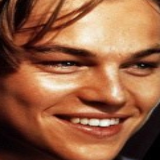

In [15]:
# you can view any of the cropped images by name
cropped_images['DiCaprio_Anchor.jpg']

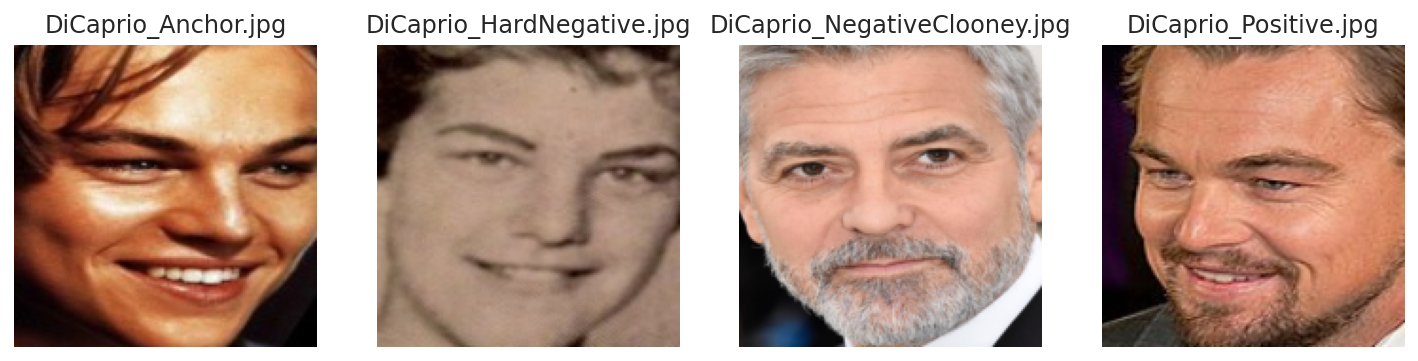

In [16]:
# or show all of the cropped images
show_cropped_images(cropped_images, num_cols=5, figsize=(10,15))   

# Step 4 - Compare Embeddings

In this step you can compare embeddings for any pair of images.

First you setup a list of "tuples", where a tuple is just a pair of image names surrounded by parentheses:

```
image_pairs = [
    ('DiCaprio_Anchor.jpg', 'DiCaprio_NegativeClooney.jpg'),
    ('DiCaprio_Anchor.jpg', 'DiCaprio_Positive.jpg'),    
    ('DiCaprio_Anchor.jpg', 'DiCaprio_HardNegative.jpg'),
]
```

Then you just run 
```
results = compare_embeddings_distance(embeddings, image_pairs)
print(results)
plot_results(results);
```

And you will see the euclidean distance between each pair of images.

In [17]:
image_pairs = [
    ('DiCaprio_Anchor.jpg', 'DiCaprio_NegativeClooney.jpg'),
    ('DiCaprio_Anchor.jpg', 'DiCaprio_Positive.jpg'),    
    ('DiCaprio_Anchor.jpg', 'DiCaprio_HardNegative.jpg'),
]

results = compare_embeddings_distance(embeddings, image_pairs)
results

,pair_num,image1,image2,euclidean_distance
0,0,DiCaprio_Anchor.jpg,DiCaprio_NegativeClooney.jpg,1.923773
1,1,DiCaprio_Anchor.jpg,DiCaprio_Positive.jpg,1.105351
2,2,DiCaprio_Anchor.jpg,DiCaprio_HardNegative.jpg,0.958094


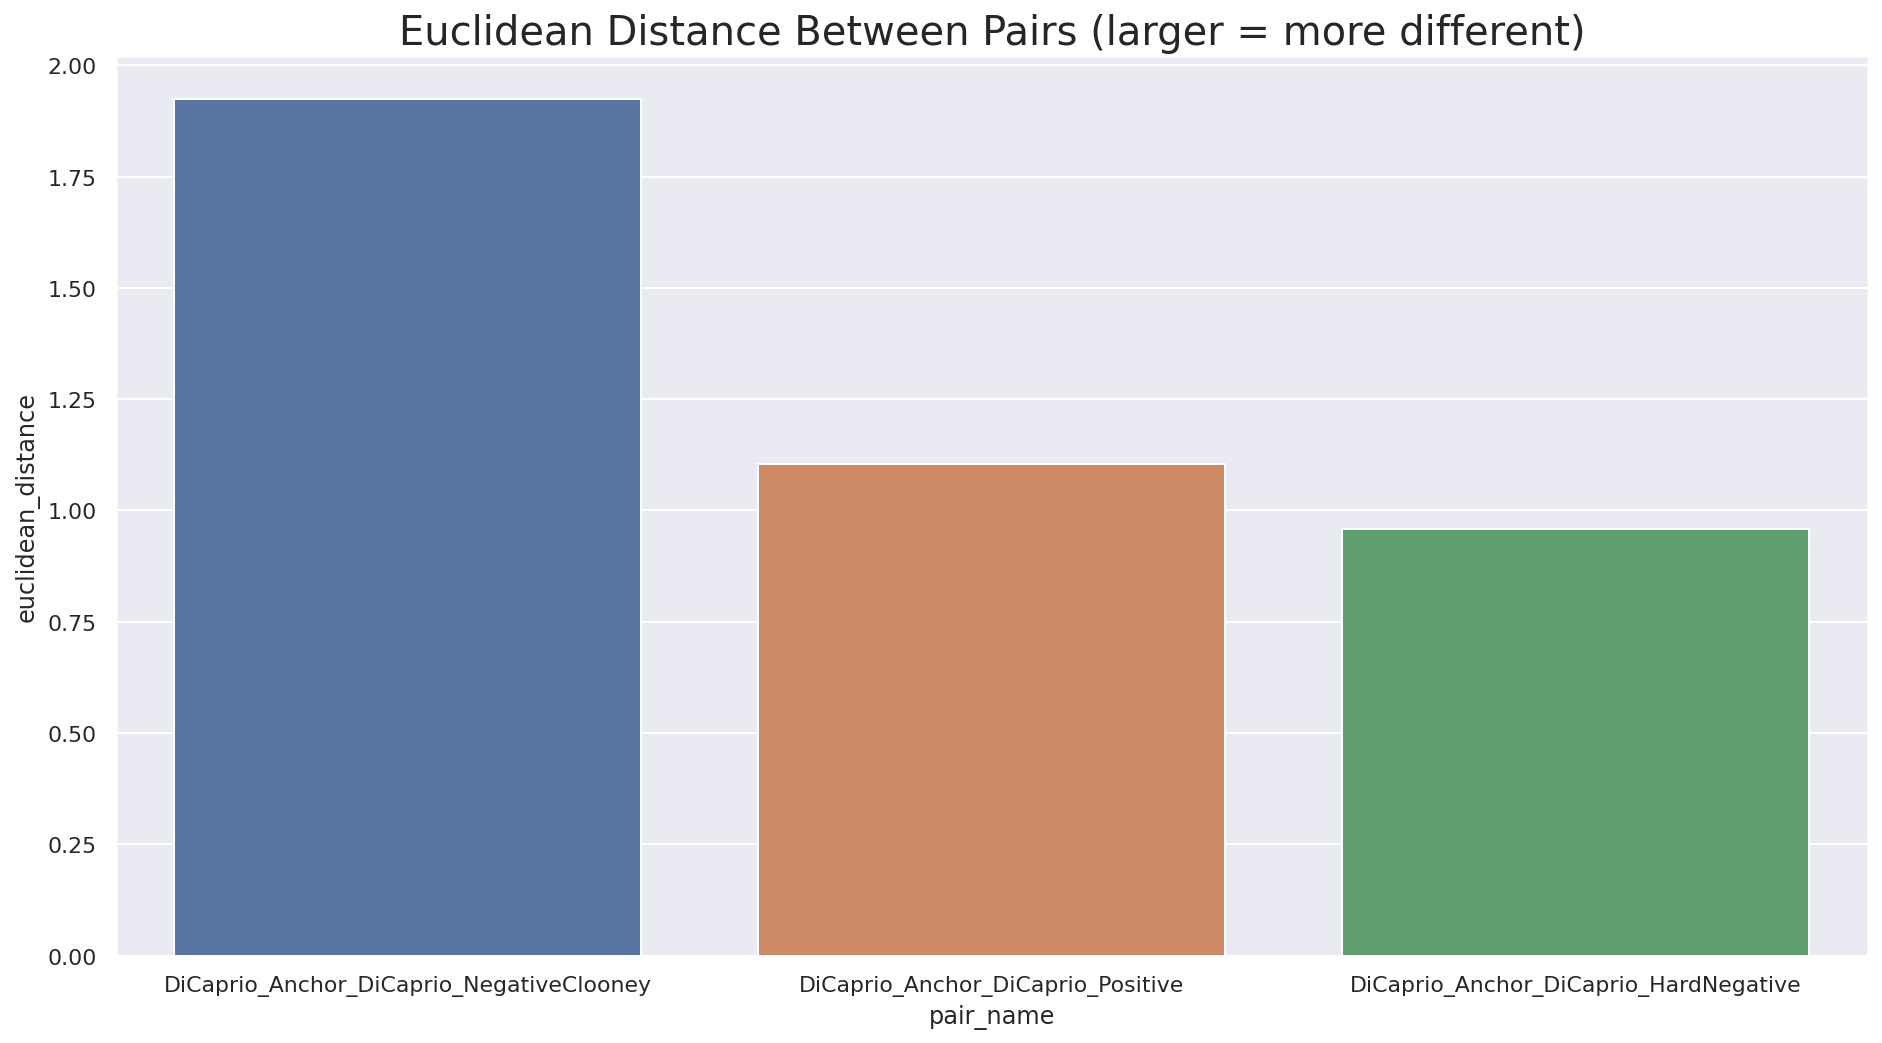

In [18]:
# plot the results
plot_results(results);

# quick sanity check to make sure all models capture basic face-similarity 

This isn't very systematic, but I just wanted to make sure FaceNetCNN and FaceVit both have descent face representations. You could provide more thorough tests if you wanted to...

Computing Embeddings (N=4 images)
model_name: FaceNetCNN


  pair_num        image1        image2  euclidean_distance
0        0  clooney1.jpg  clooney2.jpg            0.227117
1        1  clooney1.jpg     pitt1.jpg            1.916695
2        2  clooney1.jpg     pitt2.jpg            1.673627
3        3  clooney2.jpg     pitt1.jpg            1.753068
4        4  clooney2.jpg     pitt2.jpg            1.560351
5        5     pitt1.jpg     pitt2.jpg            0.303432


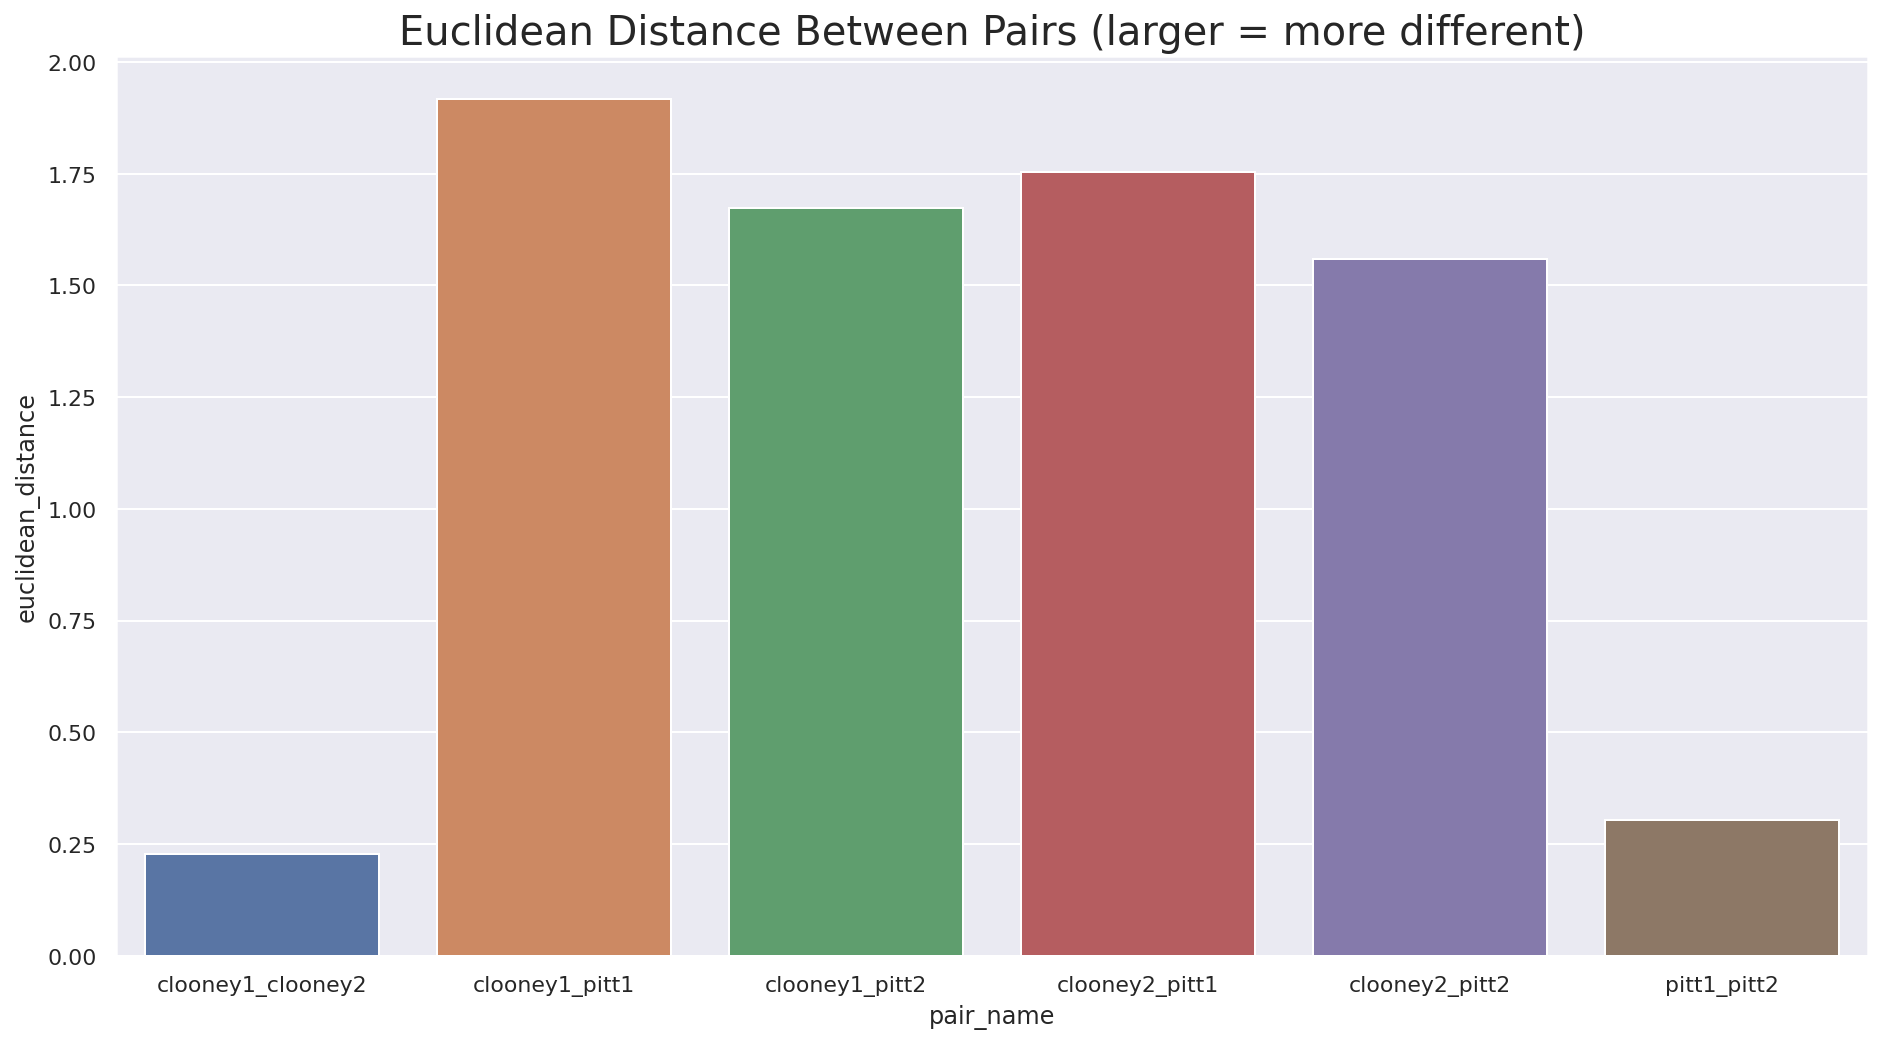

In [19]:
image_list = ['clooney1.jpg', 'clooney2.jpg', 'pitt1.jpg', 'pitt2.jpg']

# options include FaceVit, FaceVits, FaceNetCNN
# model_name = "FaceVits" 
model_name = "FaceNetCNN"
# model_name = "FaceVit"
embeddings, cropped_images = compute_embeddings(model_name, image_list)

image_pairs = [
    ('clooney1.jpg', 'clooney2.jpg'),
    ('clooney1.jpg', 'pitt1.jpg'),
    ('clooney1.jpg', 'pitt2.jpg'),    
    ('clooney2.jpg', 'pitt1.jpg'),
    ('clooney2.jpg', 'pitt2.jpg'),
    ('pitt1.jpg', 'pitt2.jpg'),
]

results = compare_embeddings_distance(embeddings, image_pairs)
print(results)
plot_results(results);